In [1]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from typing import List, Tuple
import skimage.io
import os
import pathlib
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

# Principle Component Analysis

## Helper functions
I will start by defining two functions for plotting. They will help visualize the operations we will be doing below.

In [87]:
def plot_radius_vectors(vectors: List(Tuple(int, int)), move_origin=False):
    """
    Plots 2D radius vectors on the xy-plane. Each vector is in the format (end_x, end_y).
    """
    # Extract vector coordinates
    flattened = np.array(vectors).ravel()
    end_x, end_y = flattened[::2], flattened[1::2] 

    # Plot an arrow
    start_x = np.zeros(end_x.shape)
    start_y = np.zeros(end_x.shape)
    plt.quiver(start_x, start_y, end_x, end_y, scale=1, scale_units='xy', angles = "xy")

    # Make the plot pretty (housekeeping)
    all_x = np.concatenate((start_x, end_x))
    all_y = np.concatenate((start_y, end_y))
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    correction = 1
    plt.xlim(min_x - correction, max_x + correction)
    plt.ylim(min_y - correction, max_y + correction)
       
    if move_origin:
        ax.spines['bottom'].set_position('zero')
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    ax = plt.gca()

NameError: name 'List' is not defined

In [5]:
def visualize_transformation(matrix, plot_title):
    """
    Visualize the linear transformation in 2D space with transformation matrix `matrix`
    by plotting the current and newgrid and  (before and after the transformation).
    
    `matrix` - 2x2 matrix of the linear tranformation
    """
    # Create new figure
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.axis("equal")
    
    # Modify tranformation matrix to work with Affine2D
    modified = np.concatenate((matrix, np.zeros((2,1))), axis = 1)
    modified = np.concatenate((modified, [[0, 0, 1]]),axis=0)
    
    # Current unit vectors and grid
    ax.quiver([0, 0], [0, 0], [1, 0], [0, 1], color = ["red", "blue"], alpha = 0.2, units = "xy", scale = 1)
    ax.grid()
    
    # Transform the space
    t = Affine2D(modified)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    [min_x, max_x, min_y, max_y] = [2 * ax.get_xlim()[0], 2 * ax.get_xlim()[1] + 1, 2 * ax.get_ylim()[0], 2 * ax.get_ylim()[1] + 1]
    
    # New grid lines
    # Horizontal
    for y in np.arange(min_y, max_y):
        ax.plot([min_x, max_x], [y] * 2, color = "red", linestyle = "--", linewidth = 2, transform = t + ax.transData)
    # Vertical
    for x in np.arange(min_x, max_x):
        ax.plot([x] * 2, [min_y, max_y], color = "blue", linestyle = "--", linewidth = 2, transform = t + ax.transData)

    # New unit vectors
    new_x = t.transform_affine([1, 0])
    new_y = t.transform_affine([0, 1])
    ax.quiver([0, 0], [0, 0], [new_x[0], new_y[0]], [new_x[1], new_y[1]], color = ["red", "blue"], units = "xy", angles = "xy", scale = 1)
    
    # Make the plot pretty (housekeeping)
    ax.set_xticks(np.arange(ax.get_xlim()[0], ax.get_xlim()[1] + 1))
    ax.set_yticks(np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])  
    ax.set_title(plot_title)
    plt.show()

In [9]:
# Unit test to validate the two plotting function operate properly.
A = np.array([
    [1, 2],
    [-3, 1],
])

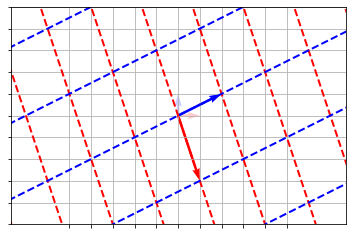

In [10]:
visualize_transformation(A, '')

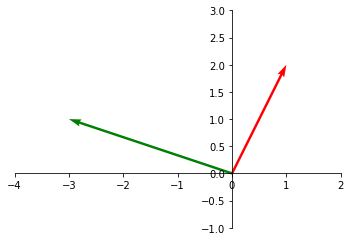

In [11]:
plot_vectors(A.tolist(), colors=['red', 'green'])

* What are eigenvalues and eigenvectors?
* What is the eigenbasis? What is the spectrum of a matrix?
* How do we compute the eigenvalues and eigenvectors of a matrix?
* What is projection?
* How does projection conserve some shapes? Think about an object casting a shadow
* How is the projection problem related to eigenvalues and eigenvectors?
* What is PCA?

* What are principal components? How many components are there (as a function of dimensions of the original space)?
* What is variance? What is explained variance?
* How do principal components relate to explained variance?
* How is PCA implemented? Implement and show
* Show some applications of PCA, e.g. reducing a 3D image to its first 2 principal components, plotting the 3D and 2D images
* Show a practical use of PCA, for example, trying to see features in a 15D space, projected in 3D.

## Eigenvalues and Eigenvectors

Lets look a following 2D example. Let $A$ be a random 2x2 matrix, for example the one defined below.

In [15]:
A = np.array([
    [0.8, 0.3],
    [0.2, 0.7],
])

If we multipy a vector $\vec x = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$ by $A$ (or any vector for that matter), the vector will be sent to a "new place" in the xy plane. Technically speaking, we are treating $A$ as a matrix of a linear tranformation:
$$ A \vec x = \vec b $$

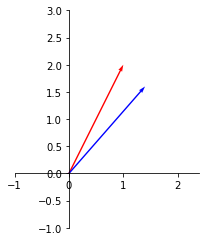

In [16]:
x = np.array([1, 2])
b = A @ x
plot_vectors([x, b], ['red', 'blue'])

It is clear the new vector $ \vec b $ has "moved". We can further transform $ \vec b $ to see the outcome: 

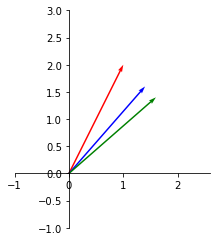

In [17]:
plot_vectors([x, b, A @ b], ['red', 'blue', 'green'])

Let's try another vector: $\vec x = \begin{bmatrix} -1 \\ 1 \end{bmatrix}$:

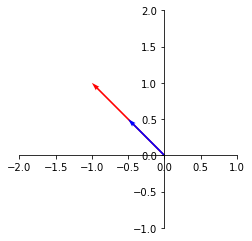

In [18]:
x = np.array([-1, 1])
b = A @ x
plot_vectors([x, b], ['red', 'blue'])

Well, that is interesting, the two vectors seem to lie on the same line. Is this a coincidence? Acutually not - I chose  $ \begin{bmatrix} -1 \\ 1 \end{bmatrix}$ on purpose, I knew what would happen in advance. Let's compare the distances of the two vectors.

In [19]:
x_len = np.sqrt(x @ x)
b_len = np.sqrt(b @ b)
b_len / x_len

0.49999999999999994

It seems to have shrunk in half (assuming there is some calculation error). Here comes a sensible question: are there more "special" vectors with the same behavior? Also, how can those be calculated? Let's write the transformation from above:
$$ A \vec x = \vec b = \lambda x$$

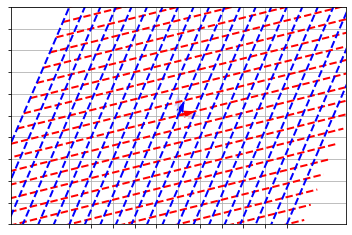

In [20]:
visualize_transformation(A, '')

In [21]:
plot_vectors([eig_vectors[1]], ['red'])
plot_vectors([eig_vectors[1], A @ eig_vectors[1]], ['red', 'blue'])
plot_vectors([eig_vectors[1], A @ eig_vectors[1], A @ A @ eig_vectors[1]], ['red', 'blue', 'green'])

NameError: name 'eig_vectors' is not defined

## Diagonalization

The great majority of matrixes are diagonizable.

In [22]:
def diagonalize(matrix):
    """
    Computes the matrix of eigenvalues.
    """
    eig_values, eig_vectors = np.linalg.eig(matrix)
    S = eig_vectors
    S_inv = np.linalg.inv(S)
    lamda_matrix = S_inv @ matrix @ S
    
    # Set very low values to 0
    tol = 1e-10
    lamda_matrix[abs(lamda_matrix) < tol] = 0
    
    return lamda_matrix

In [23]:
A = np.array([
    [0.8, 0.3],
    [0.2, 0.7],
])

B = np.array([
    [1,2,3],
    [4,5,6],
    [4,4,6],
])

# C is not diagonaisable as the eigenvectors are not independent
C = np.array([
    [2, 1],
    [0, 2],
])

for matrix in [A, B, C]:
    print(np.linalg.eigvals(matrix))
    print(diagonalize(matrix))

[1.  0.5]
[[1.  0. ]
 [0.  0.5]]
[12.2055152 -0.8113761  0.6058609]
[[12.2055152  0.         0.       ]
 [ 0.        -0.8113761  0.       ]
 [ 0.         0.         0.6058609]]
[2. 2.]
[[2. 0.]
 [0. 2.]]


## Eigenbasis

## Spectrum of a matrix

Spectrum of a matrix is the set of its eigenvalues

## Projection

Projection of a vector on another vector can be viewed from different prospectives. The most intuitive way is the geometrical. From the prospective of the linear algebra, projection is a transformation, linear operator in particular. As every other transformation, the projection has a matrix. Multiplying this matrix over any vector causes it to "move" to a new location. As we are using the same recepient vector, the projection basically compresses the 2D space to a line (in the 2D case).

Consider the example below. We will be projecting the RED vector $\vec a$ over the GRAY $\vec b$:

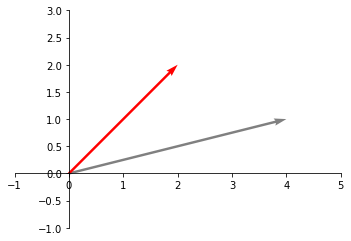

In [24]:
a = np.array([
    [4],
    [1],
])

b = np.array([
    [2],
    [2],
])

plot_vectors([a, b], ['grey', 'red'])

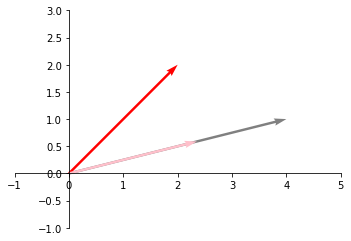

In [26]:
P = ((a @ a.T) / (a.T @ a))  # Projection matrix (rank 1)
p = P @ b  # Projection
plot_vectors([a, b, p], ['grey', 'red', 'pink'])

The projection matrix projects any vector $b$ onto the line $a$ is lying on. Basically, the 2d space is compressed in a single line (from 2 to 1 dim).

In [1]:
visualize_transformation(P, "Proj")

NameError: name 'visualize_transformation' is not defined

$I - P$ projects onto a perpendicular line (subspace in general).

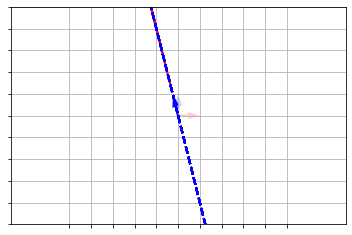

In [28]:
visualize_transformation(np.eye(2) - P, "")

The selection of $\vec{a}$ is not affecting the projection $\vec{p}$. This makes sense as $\vec{a}$ was chosen at random and also because the projection is on the **line** that $\vec{a}$ lies on.

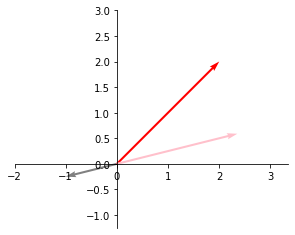

In [29]:
a = np.array([
    [-1],
    [-0.25],
])
P = ((a @ a.T) / (a.T @ a))
p = P @ b
plot_vectors([a, b, p], ['grey', 'red', 'pink'])

In [30]:
np.linalg.eig(P)

(array([1., 0.]),
 array([[ 0.9701425 , -0.24253563],
        [ 0.24253563,  0.9701425 ]]))

## Singular Value Decomposition (SVD)

We have a known non symmetric matrix $A$.

Task is to find orthonormal basis vectors $\vec{v_1}$ $\vec{v_2}$...

<div>
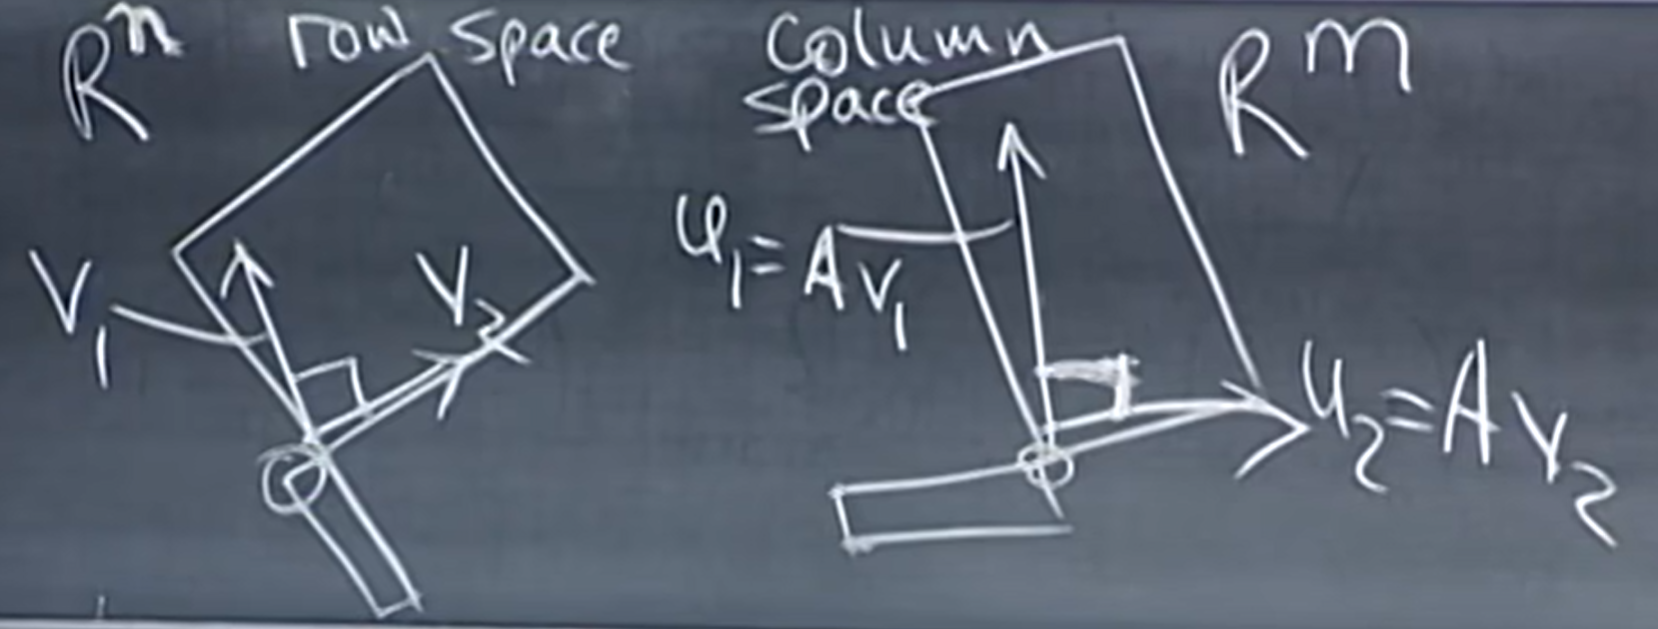
</div>

<div>
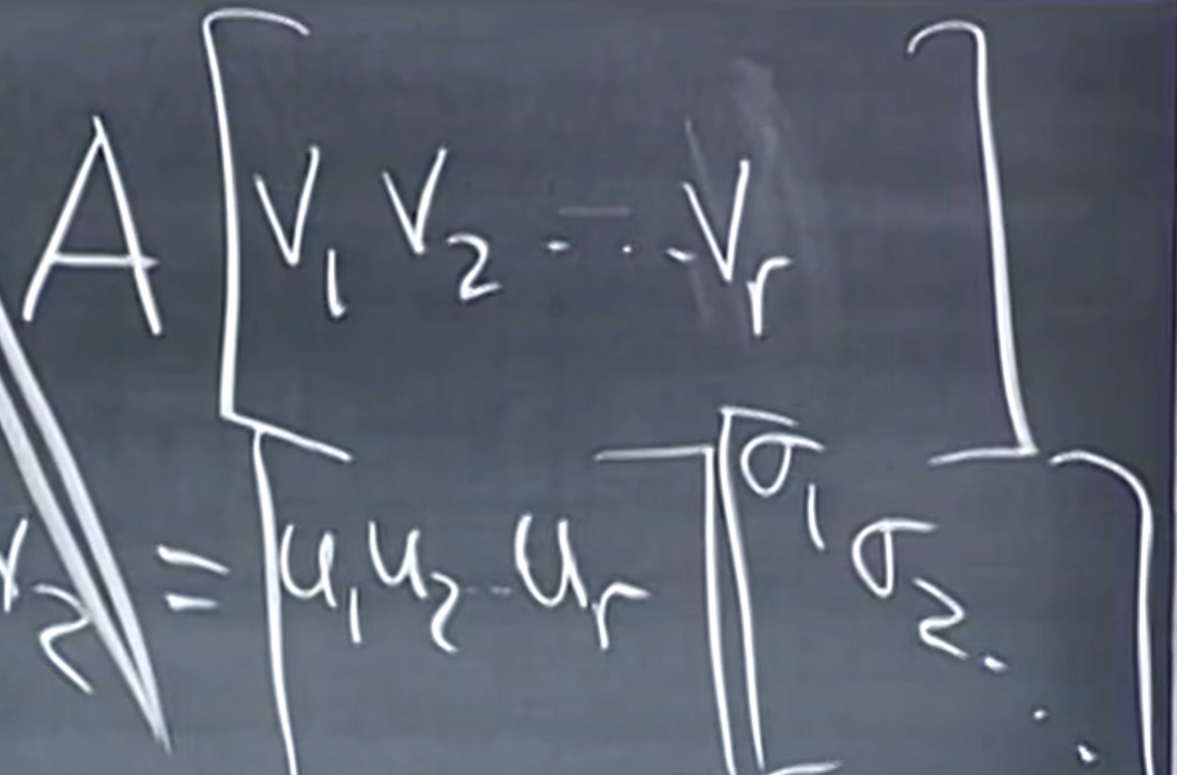
</div>

... such that after transformation $A\vec{v_1}$ the resulting basis is still ortho-normal.

<div>
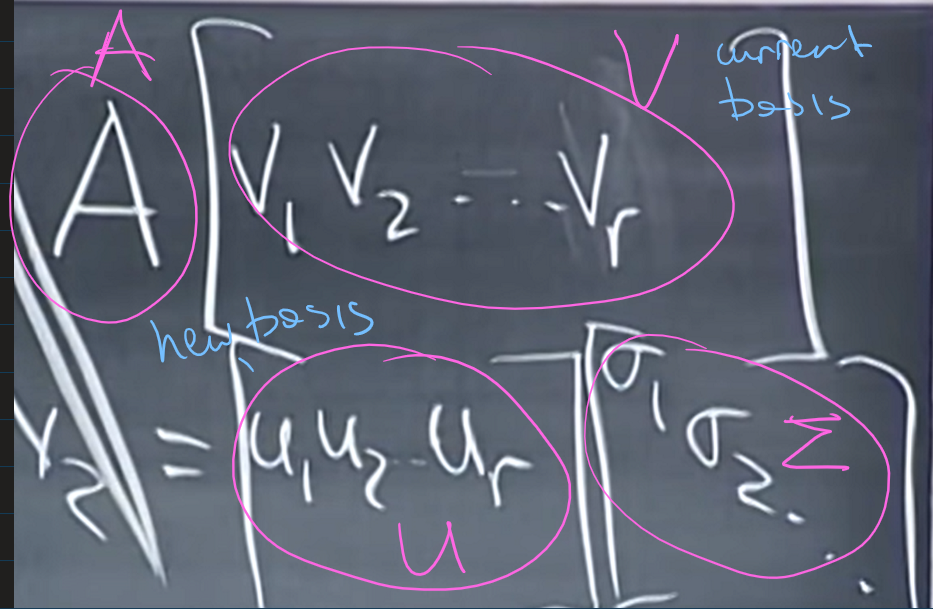
</div>

Expressed as matrices:

<div>
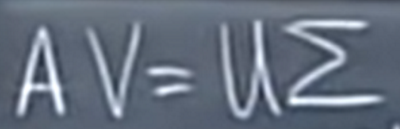
</div>

Using $A^TA$ trick to simplify:

<div>
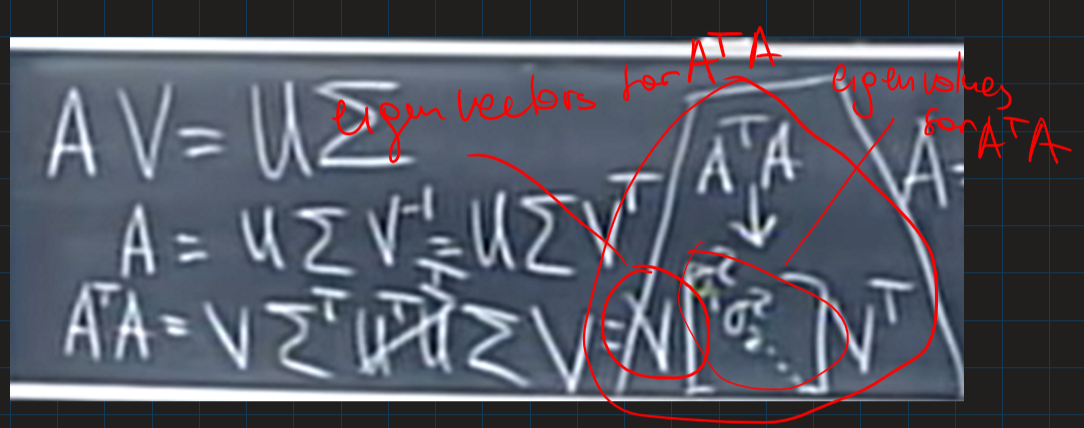
</div>

Specific Problem:

<div>
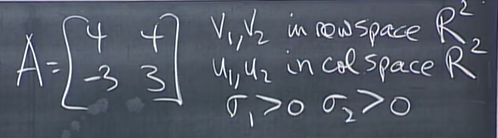
</div>

In [146]:
A = np.array([
    [4, 4],
    [-3, 3],
])

$A$ is not symmetric. For unsymmetric matrix we expect that the eigenvectors shall NOT be perpendicular. **The check** to verify is that their dot product shall not be 0: $e_1e_2 \neq 0$:

In [147]:
eigvalues, eigvectors = np.linalg.eig(A)
e1, e2 = eigvectors
e1 @ e2

(-0.14285714285714288+0j)

**Note**: when we multiply two vectors on paper, manually, we write $v^Tv$. The dot product is a number, single value.
In nupy arrays, there is no need to transpose the first vector. Actually, it will raise an error.
```python
v1 = np.array([1, 2])
v2 = np.array([2, 3])
v1 @ v2, v2 @ v1  # (8, 8), works as expected = 1*2 + 2*3
```

We can't plot the eigenvectors on the xy plane as they are complex:

In [148]:
e1, e2

(array([0.7559+0.j, 0.7559-0.j]), array([-0.0945+0.6478j, -0.0945-0.6478j]))

However, as symmetric matrix would always have orthogonal eigenvectors. To get the intuition, the following example.

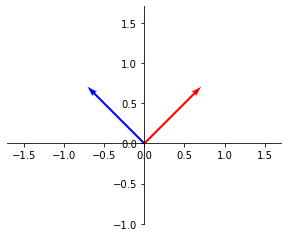

0.0

In [152]:
S = np.array([
    [4, -3],
    [-3, 4],
])
eigvalues, eigvectors = np.linalg.eig(S)
e1, e2 = eigvectors
plot_vectors([e1, e2], ['red', 'blue'])
e1 @ e2  # dot product is 0 => e1 is perpendicular to e2

Comming back to the initial problem.

<div>
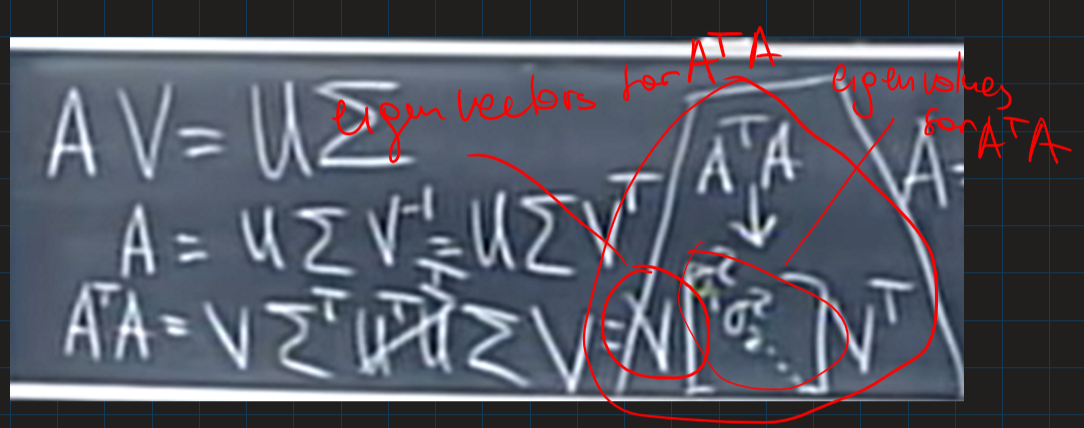
</div>

In [169]:
A = np.array([
    [4, 4],
    [-3, 3],
])

Finding the eigenvectors for $A^TA$. We expect those to be **perpendicular**. (Remember, that the eigenvectors for $A$ are complex and NOT perperndicular.)

In [226]:
A.T @ A

array([[25,  7],
       [ 7, 25]])

In [193]:
def visualize_eigenvector_perpendicularity(matrix):
    """
    Visualizes the orthogonality of the eigenvectors of a matrix.
    """
    eigvalues, eigvectors = np.linalg.eig(matrix)
    e1, e2 = eigvectors
    print(f"Eigenvectors: {e1} {e2}")
    print(f"Eigenvectors are {'perpendicular:' if e1 @ e2 == 0 else 'not perpendicular:'} e1 dot e2 = {e1 @ e2}")
    
    # Plot if eigvectors are real numbers (not complex).
    if np.iscomplex(eigvectors).any():
        return
    plot_vectors([e1, e2], ['red', 'blue'])

In [198]:
visualize_eigenvector_perpendicularity(A)

Eigenvectors: [0.7559+0.j 0.7559-0.j] [-0.0945+0.6478j -0.0945-0.6478j]
Eigenvectors are not perpendicular: e1 dot e2 = (-0.14285714285714288+0j)


Eigenvectors: [ 0.7071 -0.7071] [0.7071 0.7071]
Eigenvectors are perpendicular: e1 dot e2 = 0.0


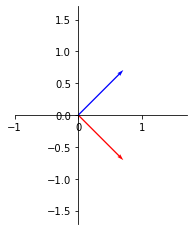

In [199]:
visualize_eigenvector_perpendicularity(A.T @ A)

Eigenvectors: [1. 0.] [0. 1.]
Eigenvectors are perpendicular: e1 dot e2 = 0.0


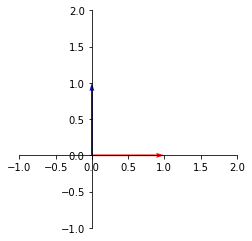

In [200]:
visualize_eigenvector_perpendicularity(A @ A.T)

Comming back to the original problem.

<div>
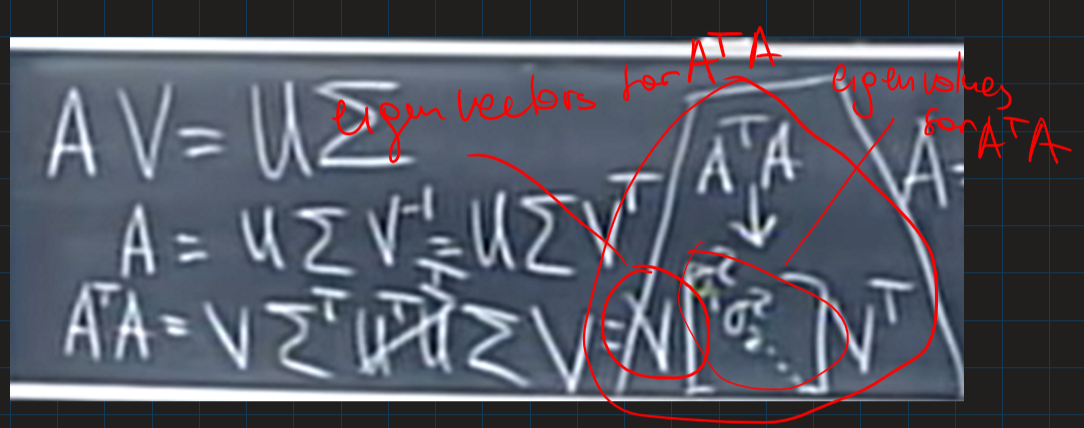
</div>

<div>
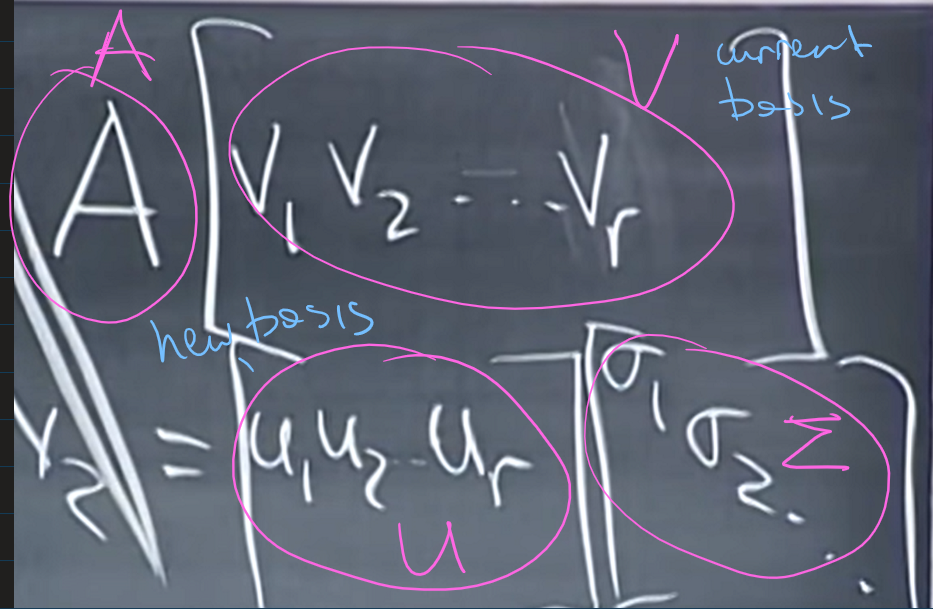
</div>

In [277]:
A = np.array([
    [4, 4],
    [-3, 3],
])

Computing the matrix comprized of the current basis vectors written as columns.

In [278]:
eigvalues, eigvectors = np.linalg.eig(A.T @ A)
V = eigvectors.T # eigenvectors for A^T A
eigvectors, eigvalues

(array([[ 0.7071, -0.7071],
        [ 0.7071,  0.7071]]),
 array([32., 18.]))

Finding $U$ in identical way.

In [279]:
eigvalues, eigvectors = np.linalg.eig(A @ A.T)
U = eigvectors.T # eigenvectors for A^T A
U, eigvalues

(array([[1., 0.],
        [0., 1.]]),
 array([32., 18.]))

Finding the $\Sigma$ matrix (=the diagonal matrix with squared $\sigma$ numbers).

In [280]:
sigma1, sigma2 = [np.sqrt(e) for e in eigvalues]
sigma1, sigma2

(5.656854249492381, 4.242640687119285)

In [281]:
S = np.array([
    [sigma1, 0],
    [0, sigma2],
])
S

array([[5.6569, 0.    ],
       [0.    , 4.2426]])

Finally, comparing the two expressions of the original equation $A = U \Sigma V^{-1}$ we are solving:

In [284]:
U @ S @ V

array([[ 4.,  4.],
       [-3.,  3.]])

In [285]:
A

array([[ 4,  4],
       [-3,  3]])

The two are equal!
In summary, we managed to decomponse (=represent as product of several matrixes; factorize) a random non-symmetric matrix to a product.

In [405]:
U, S, V

(array([[1., 0.],
        [0., 1.]]),
 array([[20., 25.],
        [25., 40.]]),
 array([[ 0.7071,  0.7071],
        [-0.7071,  0.7071]]))

## Principle Component Analysis (PCA)

**Principal component analysis (PCA)** is the **process of computing** the principal components and using them to perform a change of basis on the data.

Each data point is projected onto only the first few principal components. This way, the inital data is transformed to a lower-dimensional data but most of the data's variation is preserved.

The principal components are eigenvectors of the data's covariance matrix.

Let $A_0$ be a 2x6 matrix. Row 1 contains history grades, row2 - math grades. Each column is one student.

In [3]:
A_0 = np.array([
    [53, 46, 57, 51, 46, 47],
    [77, 64, 78, 69, 69, 63],
])

In [4]:
A_0 = np.array([
    [2.5, 0.5, 2.2, 1.9, 3.1, 2.3, 2, 1, 1.5, 1.1],
    [2.4, 0.7, 2.9, 2.2, 3.0, 2.7, 1.6, 1.1, 1.6, 0.9],
])

Subtracting the mean of each row from the elements in the row (this action is called **centering**):

In [5]:
means = A_0.mean(axis=1, keepdims=True)
A = A_0 - means
A

array([[ 0.69, -1.31,  0.39,  0.09,  1.29,  0.49,  0.19, -0.81, -0.31,
        -0.71],
       [ 0.49, -1.21,  0.99,  0.29,  1.09,  0.79, -0.31, -0.81, -0.31,
        -1.01]])

Sample covariance $S$:

In [6]:
n = A.shape[1] # number of columns
S = A @ A.T / (n - 1)
S

array([[0.61655556, 0.61544444],
       [0.61544444, 0.71655556]])

In [8]:
eigvalues, eigvectors = np.linalg.eig(S)
eigvalues, eigvectors

(array([0.0490834 , 1.28402771]),
 array([[-0.73517866, -0.6778734 ],
        [ 0.6778734 , -0.73517866]]))

In [14]:
principle_component = eigvectors[:,[1]]

In [22]:
A_t = principle_component.T.ravel() @ A

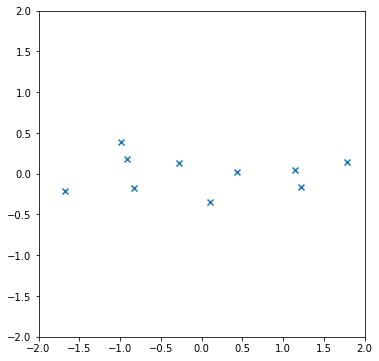

In [41]:
l = eigvectors[:,::-1].T @ A
plt.figure(figsize=(6,6))
plt.scatter(l[0], l[1], marker='x')
ax = plt.gca()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax.set_aspect("equal")

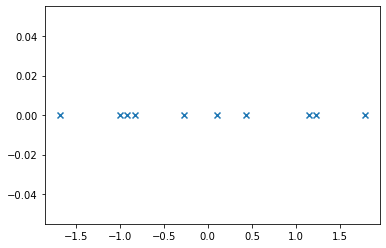

In [43]:
plt.scatter(A_t, np.zeros(A_t.size), marker='x')


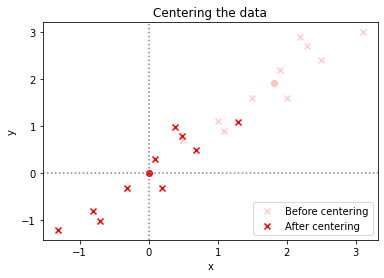

In [86]:

x, y = A_0
plt.scatter(x, y, marker='x', label="Before centering", alpha=0.2, color='red')
plt.scatter(np.mean(x), np.mean(y), marker='o', alpha=0.2, color='red') 
x, y = A
plt.scatter(x, y, marker='x', label="After centering", color='red')
plt.scatter(np.mean(x), np.mean(y), marker='o', color='red') 

plt.axvline(color='gray', linestyle=':')
plt.axhline(color='gray', linestyle=':')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Centering the data")
plt.show()

In [2]:
x, y = A
plt.scatter(x, y, marker='x')
for e in eigvectors:
    plt.axline((0, 0), (e[0], e[1]), linestyle='--',color='purple')

plt.xlim(-5, 5)
plt.ylim(-5, 5)

ax = plt.gca()
ax.set_aspect('equal')
plt.show()

NameError: name 'A' is not defined

In [ ]:
p = pathlib.Path(r'C:/Users/a1056968/Desktop/faces').glob('**/*')
s = '8.'
files = [x for x in p if x.is_file() and x.name.startswith(s)]
files[:3]

[WindowsPath('C:/Users/a1056968/Desktop/faces/s1/8.pgm'),
 WindowsPath('C:/Users/a1056968/Desktop/faces/s10/8.pgm'),
 WindowsPath('C:/Users/a1056968/Desktop/faces/s11/8.pgm')]

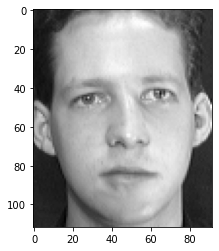

In [ ]:
images = np.array([skimage.io.imread(file) for file in files])

for image in images[:1]:
    plt.imshow(image, cmap='gray')
    plt.show()

In [ ]:
# # Lower resolution
# resolution = (128,96)
# rescaled = np.array([cv2.resize(img, dsize=resolution, interpolation=cv2.INTER_CUBIC) for img in images])
# plt.imshow(rescaled[0], cmap='gray')

In [ ]:
# Change image to 1D
x, y, z = images.shape
A_00 = images.reshape(x, y * z)
images.shape, A_00.shape

((40, 112, 92), (40, 10304))

In [ ]:
A_0 = A_00
A_0.shape

(40, 10304)

In [ ]:
_, h, w = images.shape
X = data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(A_0, y, test_size=0.3)

In [ ]:
means = A_0.mean(axis=0, keepdims=True)
A = A_0 - means
A[:,300].mean(), A_0[:,300].mean()

(0.0, 74.0)

In [ ]:
# plt.figure(figsize=(10,60))
# plt.imshow(A_0,cmap='gray')
# plt.show()
# plt.imshow(A)

Sample covariance $S$:

In [ ]:
n = A.shape[1] # number of columns
S = A @ A.T / (n - 1)
S.shape

(40, 40)

In [ ]:
eigvalues, eigvectors = np.linalg.eig(S)
eigvalues.shape, eigvectors.shape

((40,), (40, 40))

In [ ]:
components_num = 10
components = eigvectors[:components_num]
components.shape, A.shape

((10, 40), (40, 10304))

In [ ]:
A_t = components @ A
A_t.shape

(10, 10304)

((10, 112, 92), (112, 92))

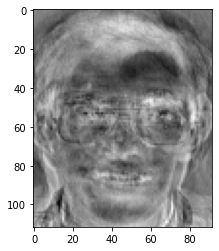

In [ ]:
final = A_t.reshape((components_num, 112, 92))
mean_face = final.mean(axis=0)
plt.imshow(mean_face, cmap='gray')

final.shape, final.mean(axis=0).shape

In [3]:
for f in final[:1]:
    plt.imshow(f, cmap='gray')
    plt.show()

NameError: name 'final' is not defined

In [337]:
def interpolate_polynomial(points, degree, min_x=5, max_x=5):
    """
    Interpolates a polynomial of the specified degree through the given points and plots it
    points - a list of points (x, y) to plot
    degree - the polynomial degree
    min_x, max_x - range of x values used to plot the interpolating polynomial
    """
    # Write data points in a np.array()
    points = np.array(points)

    # Extract x and y corrdinates
    x = points[:, 0]
    y = points[:, 1]

    # Calculate the interpolating polynomial. Polynomial degree is set up to len(points) - 1
    coefficients = np.polyfit(x, y, degree)
    poly = np.poly1d(coefficients)

    # Generate values for x and calculate the corresponding polynom values
    plot_x = np.linspace(min_x, max_x, 1000)
    plot_y = poly(plot_x)

    # Plot both the polynom and the data points
    plt.plot(plot_x, plot_y, c = "green")
    plt.scatter(x, y)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

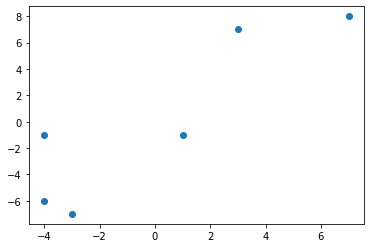

In [338]:
plt.scatter(A[0], A[1])
plt.show()

In [346]:
points = sorted([tuple(i) for i in A.T])
points

[(-4.0, -6.0), (-4.0, -1.0), (-3.0, -7.0), (1.0, -1.0), (3.0, 7.0), (7.0, 8.0)]

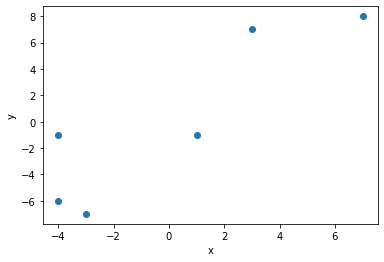

In [347]:
interpolate_polynomial(points, 1, 5, max_x=5)

In [381]:
[list(i) for i in A.T]

[[3.0, 7.0], [-4.0, -6.0], [7.0, 8.0], [1.0, -1.0], [-4.0, -1.0], [-3.0, -7.0]]

In [1]:
A.tolist()


NameError: name 'A' is not defined

### Terms and conditions:
By submitting your project for the exam, you agree with the following:
* Use Jupyter notebook for text and maths. You can use any programming language you would like.
* Write your research and code in English. Bulgarian is also acceptable but try to use English.
* If you have sensitive, copyrighted, or copy-protected assets, including but not limited to, images, multimedia, code, documents, and datasets,
  you can sign an NDA (non-disclosure agreement) with the SoftUni team. Contact the lecturer if you need assistance with the process.
* Any code which does not comply with the Bulgarian law (as of the exam date), will be given zero points.
* Any malicious code, or code intended to do harm to the user's computer, information, or privacy, will be given zero points.

### Self-assessment:
The numbers in brackets define possible points for the corresponding item.

1. Problem statement (0-10)
	* How well is the problem defined?
	* Does the research address a real-life problem?
	* Does the research solve the correct problem?
2. Layout (0-20)
	* Are the document sections structured properly?
	* Is the article well-formatted (in terms of readability)?
3. Code quality (0-20)
	* Is the code well-written? Is the code self-documenting?
	* Is the code organized into functions?
	* Is the code generally well-structured?
4. Previous research (0-10)
	* Have you cited at least two other sources?
	* Does the project contain comparisons between the current and the previous results?
5. Gathering / generating, cleaning, and formatting data (0-10)
	* Every problem deals with "real-world" data in some way. Even if you don't use datasets, you'll likely generate some data
	* How is the data gathered?
	* Is the process statistically valid?
	* Is the process of data acquisition, data cleaning, and data manipulation well documented?
6. Testing (0-10)
	* This can have various meanings: unit testing, hypothesis testing, train / test data set, etc.
	* Is the code thoroughly tested?
	* Are there any comparisons to other implementations / other articles / previous research?
7. Visualization (0-10)
	* All kinds of projects employ some visualization: graphical plots, tables, etc.
	* Are all visualizations correct (i.e. convey the intended meaning without misleading the intended audience)?
	* Are all visualizations clear, and easy to understand?
8. Communication (0-10)
	* Does the project tell the story correctly?
	* Does the project serve the audience it was intended for?